# Imports and setup

In [8]:
import os
import re
import math
import json
import random
from collections import Counter

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

import pickle
from openai import OpenAI

from utils.items import Item
from utils.evaluation import ModelEvaluator

In [9]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [10]:
openai = OpenAI()

In [11]:
try:
    with open('train.pkl', 'rb') as file:
        train = pickle.load(file)
except FileNotFoundError as e:
    print(e)

try:
    with open('test.pkl', 'rb') as file:
        test = pickle.load(file)
except FileNotFoundError as e:
    print(e)

We will use 200 samples for finetuning openai and 50 samples as validation set.

In [12]:
fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Prepare data for finetuning

## Create JSONL file 
Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [13]:
# First let's work on a good prompt for a Frontier model

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [14]:
messages_for(fine_tune_train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [16]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [17]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

In [18]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [19]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [20]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

train_file

FileObject(id='file-UouLM8s1Se5cjPshKAmctq', bytes=188543, created_at=1744870408, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [21]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

validation_file

FileObject(id='file-7s1vFyyGNFNWVLV5JsWSyS', bytes=47036, created_at=1744870443, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

## Finetuning 

In [22]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [23]:
train_file.id

'file-UouLM8s1Se5cjPshKAmctq'

In [24]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-G56JUhv6PbQqcQRv8uALRsEd', created_at=1744870473, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-r29WQKpIGCvzmSMSQuqKncaW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UouLM8s1Se5cjPshKAmctq', validation_file='file-7s1vFyyGNFNWVLV5JsWSyS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G56JUhv6PbQqcQRv8uALRsEd'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [29]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-G56JUhv6PbQqcQRv8uALRsEd', created_at=1744870473, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-r29WQKpIGCvzmSMSQuqKncaW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UouLM8s1Se5cjPshKAmctq', validation_file='file-7s1vFyyGNFNWVLV5JsWSyS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G56JUhv6PbQqcQRv8uALRsEd'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix=

In [30]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [31]:
job_id

'ftjob-G56JUhv6PbQqcQRv8uALRsEd'

In [32]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-G56JUhv6PbQqcQRv8uALRsEd', created_at=1744870473, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-r29WQKpIGCvzmSMSQuqKncaW', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-UouLM8s1Se5cjPshKAmctq', validation_file='file-7s1vFyyGNFNWVLV5JsWSyS', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-G56JUhv6PbQqcQRv8uALRsEd'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [45]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-1E38BNgZKqRKd7YMawtyXAra', created_at=1744871123, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-jlLUCEABF5bmtXFnMhy3Ni6I', created_at=1744871118, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-J9eaIwoMIhBAAjwnG2S4rZpt', created_at=1744871052, level='info', message='Step 200/200: training loss=1.13, validation loss=1.11, full validation loss=1.12', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.1326918601989746, 'valid_loss': 1.1092033386230469, 'total_steps': 200, 'full_valid_loss': 1.1151207828521728, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7925}, type='metrics'),
 FineTuningJobEvent(id='ftevent-E7GZnUCC1Ij2VHjuGalzVw4T', created_at=1744871046, level='info', message='Step

## Test the finetuned model

In [46]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [47]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BNCyUHED'

In [48]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [49]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [50]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [51]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [52]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
490.0


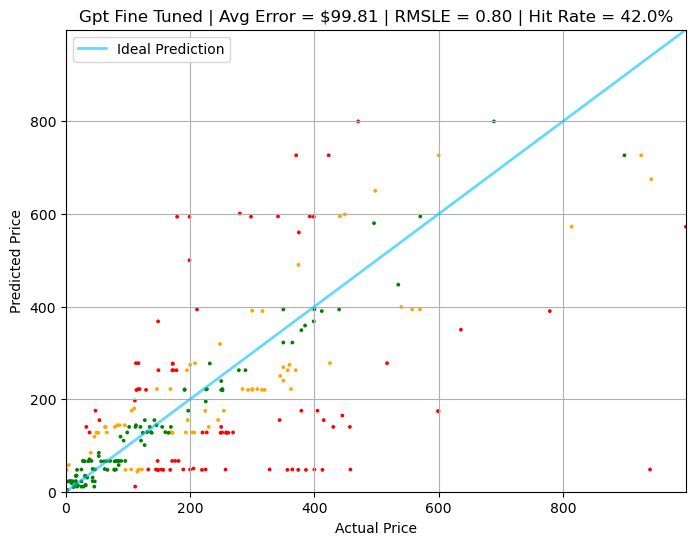

In [53]:
ModelEvaluator.evaluate(gpt_fine_tuned, test)